# Predict household income from satellite imagery data

First pass.

General ML pipeline steps:
1. Import data
2. Split data into test/train sets
3. Preprocess test/train sets separately
4. Generate features from data
5. For each regressor-hyperparameter combination:
    - Train regressor with given hyperparameters and training data and labels
    - Generate predicted labels for test data with trained regressor
    - Evaluate regressor-hyperparameter performance against actual test labels and get $R^2$
6. Explore best-performing models

In [1]:
import os
import math
import pickle
import numpy as np
import pandas as pd 
import geopandas as gpd

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import seaborn as sns

# Import configuration file
import config as cf

# Turn off big pink warnings
import warnings
warnings.filterwarnings('ignore')

# Display options 
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1

# Data file path 
# final_data_file_path = "/Users/robmarty/Dropbox/World Bank/IEs/Pakistan Poverty Estimation from Satellites/Data/FinalData"

# Set directory
os.chdir("/Users/nguyenluong/wb_internship/Data")

In [2]:
# Test grid to make sure everything works - limited models and parameters
# 'BaggingClassifier'

GRID_TEST_CLASS = {
    'regressors': ['AdaBoostClassifier',
                   'KNeighborsClassifier', 
                   'RandomForestClassifier', 
                   'GradientBoostingClassifier', 
                   'LinearSVC',
                   'SVC', 
                   'DecisionTreeClassifier'],
    'KNeighborsClassifier': [
        {'n_neighbors': n_neighbors} \
        for n_neighbors in (2,5,10,15,) 
    ],
    'LinearSVC': [
        {'penalty': penalty, 'C': C, 'loss': loss, 'max_iter': max_iter,
        'random_state': 0} \
        for penalty in ('l2', ) \
        for C in (1e-2,1,2) \
        for loss in ('epsilon_insensitive','squared_hinge', ) \
        for max_iter in (1e1, )
    ],
    'SVC': [
        {'kernel': kernel, 'C': C, 'class_weight': class_weight,         
        'random_state': 0} \
        for C in (1e-2,1,2) \
        for class_weight in (None, 'balanced',) \
        for kernel in ('linear','poly','rbf','sigmoid', ) \
    ],
    'DecisionTreeClassifier': [
        {'criterion': criterion, 'splitter': splitter, 'max_depth': max_depth,
        'max_features': max_features, 'random_state': 0} \
        for criterion in ('gini', ) \
        for splitter in ('best', ) \
        for max_depth in (1,2,3,4, 5, 10, 20, 30, 50, 70, 100, ) \
        for max_features in ('sqrt', ) \
    ],
    'BaggingClassifier': [
        {'n_estimators': n_estimators, 'max_features': max_features,
        'random_state': 0, 'n_jobs': -1} \
        for n_estimators in (10, 50, 100, 1000,) \
        for max_features in (0.1, 0.2, 0.3,0.4, 0.5, 1.0,)
    ],
    'AdaBoostClassifier': [
        {'n_estimators': n_estimators, 
         'base_estimator': base_estimator,
        'random_state': 0} \
        for n_estimators in (5, 10, 50, 100) \
        for base_estimator in (None, 
                                DecisionTreeClassifier(max_depth=2), 
                                DecisionTreeClassifier(max_depth=5),
                              DecisionTreeClassifier(max_depth=6),
                              DecisionTreeClassifier(max_depth=10),
                              DecisionTreeClassifier(max_depth=15))
    ],
    'RandomForestClassifier': [
        {'n_estimators': n_estimators, 'criterion': criterion,
        'max_depth': max_depth, 'max_features': max_features, 'n_jobs': -1,
        'random_state': 0} \
        for n_estimators in (5, 10, 100, 1000, 5000) \
        for criterion in ('gini', ) \
        for max_depth in (1,2,3,4,5,6,7,8,9,10, ) \
        for max_features in ('sqrt','log2',None, )
    ],
    'GradientBoostingClassifier': [
        {'loss': loss, 'learning_rate': rate, 'n_estimators': n_estimators,
        'criterion': criterion, 'max_features': max_features,
        'random_state': 0} \
        for loss in ('deviance', ) \
        for rate in (1e-4, )
        for n_estimators in (100, ) \
        for criterion in ('friedman_mse', ) \
        for max_features in ('sqrt', ) \
    ]
}

## 1. Import data and drop "future" rows

### 1.1 Import BISP data

In [218]:
#### Predict Changes
# DATA_PATH = os.path.join(final_data_file_path, 'BISP','Merged Datasets', 'bisp_socioeconomic_satellite_firstdiff_r13.csv')
# DATA_PATH = os.path.join('/Users/robmarty/Desktop/', 'bisp_socioeconomic_satellite_firstdiff_r13.csv')

#### Predict Levels
DATA_PATH = os.path.join('BISP', 'bisp_socioeconomic_satellite_panel_full_satPovNAsRemoved_1hh.csv')

df = pd.read_csv(DATA_PATH)
df.shape

(4528, 502)

In [219]:
# Restrict to Year
df = df[df['year'] == 2014]
df.shape

(3273, 502)

### 1.2 Choose transformation for DV (poverty)

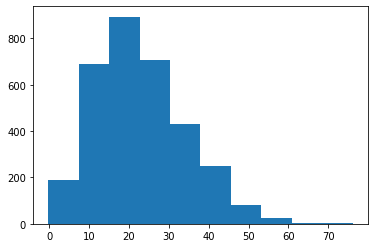

In [225]:
# Look at distribution
plt.hist(df['pscores']);

In [226]:
### Binary
# df = df[df['pscores_bin'] != 1]
# df = df[df['pscores_bin'] != 2]
# df['pscores_bin'] = (df['pscores_bin'] == 0)

### Changes
#df['pscores_bin'] = df['pscores'] < 0

#### Levels
#df = df.loc[df['survey_round'] != 1]
#df['pscores_bin'] = df['pscores'] <= (df['pscores'].median())
#df['pscores_bin'] = df['pscores_poor']

### DV as Quantiles
#df['pscores_bin'] = pd.qcut(df['pscores'], 4, labels=False)
#df['pscores_2011'].value_counts()
#df['pscores_bin'] = df['pscores'] < 0

### Clustered by K-Means
from sklearn.preprocessing import KBinsDiscretizer
pscores = df['pscores'].to_numpy().reshape(-1,1)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
df['pscores_bin'] = discretizer.fit_transform(pscores)

df.pscores_bin.value_counts()

1.0    970
2.0    836
0.0    701
3.0    569
4.0    197
Name: pscores_bin, dtype: int64

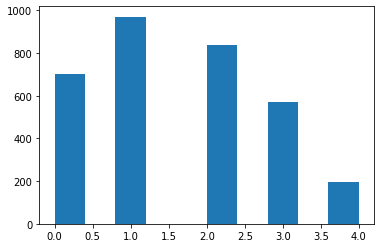

In [234]:
plt.hist(df['pscores_bin'], range=[0, 4]);

### 1b. Import NTL data

In [ ]:
# Load satellite data
viirs_gdf = gpd.read_file('satellite_raw/VIIRS/viirs_annual_polygon.geojson')
viirs_gdf = viirs_gdf[['median_rad_2014', 'tile_id', 'geometry']]
viirs_gdf.head(2)

### 1c. Match BISP HHs to Coordinates

In [19]:
# Load BISP coordinate info
coords = pd.read_stata('BISP/GPS_uid_crosswalk.dta')

from math import floor
def get_lat_lon(number):
    deg = floor(number / 100)
    min = floor(number - (100 * deg))
    sec = 100 * (number - (100 * deg) - min)
    degree = deg + (min / 60) + (sec / 3600)
    return degree

# Drop NAs
coords = coords[~coords['GPSN'].isna()]

# Get lat, lon
coords['lat'] = coords['GPSN'].apply(lambda x: get_lat_lon(x))
coords['lon'] = coords['GPSE'].apply(lambda x: get_lat_lon(x))

# Convert uid to integer
coords['uid'] = coords['uid'].astype(int)

# Create geopandas
coords = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords['lon'], coords['lat']))
coords.head()

,GPSN,GPSE,uid,lat,lon,geometry
0,3349.405,7241.680,104989,33.827917,72.702222,POINT (72.70222 33.82792)
1,3349.403,7241.698,100389,33.827861,72.702722,POINT (72.70272 33.82786)
2,3349.392,7241.730,101236,33.827556,72.703611,POINT (72.70361 33.82756)
3,3349.383,7241.486,105557,33.827306,72.696833,POINT (72.69683 33.82731)
4,3349.370,7241.639,101915,33.826944,72.701083,POINT (72.70108 33.82694)


In [20]:
# Match coords to HHs in df
gdf_bisp = coords.merge(df, left_on='uid', right_on='uid')
gdf_bisp.shape

(3273, 508)

### 1d. Join Bisp data and NTL data
Bisp HHs located in an NTL tile/poly are linked to that NTL radiance value 

In [110]:
# Spatial join HHs with satellite viirs
gdf = gpd.sjoin(viirs_gdf, gdf_bisp, how="inner", op='intersects').reset_index(drop=True)
# Reset index because multiple HHs may belong to one NTL tile

In [111]:
# Inspect range of tiles represented
print(gdf.shape)
gdf['tile_id'].unique()

(3259, 511)


array([40., 36., 38., 37., 32., 33., 31., 34., 28., 29., 30., 27., 26.,
       25., 23., 20., 21., 22., 24., 19., 15., 14., 13.,  9.,  8., 10.,
        1.,  2.])

### 1e. Map DTL image files to data

In [22]:
# Specify autoreload
%load_ext autoreload
%autoreload 2

# Import helper functions
import feature_extraction as fe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
DTL_directory = os.path.join('satellite_raw', 'Landsat', '2014')
DLT, processed_gdf = fe.map_DTL_NTL(gdf, DTL_directory)

In [119]:
processed_gdf.shape # 6 observations correspond to DTL images that are irregular in shape and were dropped

(3223, 511)

In [152]:
# Keep Select Columns
df_viirs = processed_gdf.filter(regex='viirs').filter(regex='_2km')
df_landsat = processed_gdf.filter(regex='^b').filter(regex='_1km')
df_osm = processed_gdf.filter(regex='fclass').filter(regex='meters')
df_facebook = processed_gdf.filter(regex='^estimate_dau')

df_y = processed_gdf.filter(regex='^pscores_bin$')

# Reset index because 6 observations and indexes dropped throughout
df_final = df_y.join(df_osm).join(df_facebook).reset_index(drop=True)

# Drop columns where the label is missing
#df = df.loc[~pd.isnull(df['hhinc_2011'])]

### 1f. Use CNN to extract features from DTL

In [131]:
# Reshape DTL like in CNN training
print('Original DTL shape: {}'.format(DLT.shape))
height, width, channels = 25, 26, 7
DLT = DLT.reshape((DLT.shape[0], height, width, channels))
print('DTL after reshaping: {}'.format(DLT.shape))

Original DTL shape: (3223, 7, 1, 25, 26)
DTL after reshaping: (3223, 25, 26, 7)


In [153]:
### Save objects for later
#processed_gdf.to_pickle('saved_objects/processed_gdf.pkl')
#df_final.to_pickle('saved_objects/df_final.pkl')
#np.save('saved_objects/poverty_DLT', DLT)

### Restart here
processed_gdf = pd.read_pickle('saved_objects/processed_gdf.pkl')
df_final = pd.read_pickle('saved_objects/df_final.pkl')
DLT = np.load('saved_objects/poverty_DLT.npy')

In [3]:
# Load CNN
from keras.models import load_model
model = load_model('best_CNN.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 21, 22, 64)        11264     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 10, 11, 64)        0         
_________________________________________________________________
flatten1 (Flatten)           (None, 7040)              0         
_________________________________________________________________
dense1 (Dense)               (None, 100)               704100    
_________________________________________________________________
dense2 (Dense)               (None, 5)                 505       
Total params: 715,869
Trainable params: 715,869
Non-trainable params: 0
_________________________________________________________________


In [154]:
# Extract features
df_features = fe.extract_features(model, DLT, 'dense1')
df_features

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95,feat_96,feat_97,feat_98,feat_99
0,0.0,0.0,0.0,2366.600586,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,2522.061035,0.0,0.0,0.000000,3883.045410,1161.409058,0.0,0.0,0.0,0.000000,238.642548,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1133.368286,0.0,0.000000,0.000000,0.0,0.000000,580.302917,0.0,0.0,0.0,3263.840088,0.0,4744.113281,1212.678589,0.000000,0.0,255.813400,0.000000,2941.686523,783.1427,2031.683960,0.000000,0.000000,1191.658081,0.0,0.000000,2260.906006,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,823.855957,0.000000,0.000000,0.0,0.0,0.0,0.0,5688.450684,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,2094.69873,0.0,0.0,0.0,0.0,0.0,76.956139,0.0,0.0,0.0,50.866501,0.000000,0.0,774.081848,0.000000,64.622139,888.501709,0.0,2103.291504
1,0.0,0.0,0.0,0.000000,709.257812,0.000000,0.000000,0.0,0.0,0.0,0.0,1090.323486,940.399719,0.000000,0.0,0.0,543.331787,2957.527100,1878.533325,0.0,0.0,0.0,43.681442,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,2097.463135,0.0,0.000000,0.000000,0.0,363.357880,0.000000,0.0,0.0,0.0,0.000000,0.0,733.075867,0.000000,1149.308472,0.0,0.000000,555.367981,2108.306396,0.0000,1365.018066,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,185.2397,339.253754,0.0,0.000000,2376.997070,403.180664,0.0,0.0,0.0,0.0,4283.085938,0.000000,0.0,0.0,0.0,0.000000,575.385620,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,801.021912,418.039246,0.0,0.000000,0.000000,0.000000,0.000000,0.0,976.908203
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,145.494598,0.000000,0.000000,0.0,0.0,0.000000,850.374268,410.606262,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,499.948822,0.000000,0.0000,492.802155,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2059.481201,0.000000,0.0,0.0,0.0,0.000000,5.064293,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,145.494598,0.000000,0.000000,0.0,0.0,0.000000,850.374268,410.606262,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,499.948822,0.000000,0.0000,492.802155,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2059.481201,0.000000,0.0,0.0,0.0,0.000000,5.064293,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,145.494598,0.000000,0.000000,0.0,0.0,0.000000,850.374268,410.606262,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,499.948822,0.000000,0.0000,492.802155,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,

### 1g. Select extracted features to include

In [155]:
# Join features with pscores_bin
df_features = df_final['pscores_bin'].to_frame().join(df_features)
df_features

,pscores_bin,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95,feat_96,feat_97,feat_98,feat_99
0,2,0.0,0.0,0.0,2366.600586,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,2522.061035,0.0,0.0,0.000000,3883.045410,1161.409058,0.0,0.0,0.0,0.000000,238.642548,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1133.368286,0.0,0.000000,0.000000,0.0,0.000000,580.302917,0.0,0.0,0.0,3263.840088,0.0,4744.113281,1212.678589,0.000000,0.0,255.813400,0.000000,2941.686523,783.1427,2031.683960,0.000000,0.000000,1191.658081,0.0,0.000000,2260.906006,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,823.855957,0.000000,0.000000,0.0,0.0,0.0,0.0,5688.450684,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,2094.69873,0.0,0.0,0.0,0.0,0.0,76.956139,0.0,0.0,0.0,50.866501,0.000000,0.0,774.081848,0.000000,64.622139,888.501709,0.0,2103.291504
1,1,0.0,0.0,0.0,0.000000,709.257812,0.000000,0.000000,0.0,0.0,0.0,0.0,1090.323486,940.399719,0.000000,0.0,0.0,543.331787,2957.527100,1878.533325,0.0,0.0,0.0,43.681442,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,2097.463135,0.0,0.000000,0.000000,0.0,363.357880,0.000000,0.0,0.0,0.0,0.000000,0.0,733.075867,0.000000,1149.308472,0.0,0.000000,555.367981,2108.306396,0.0000,1365.018066,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,185.2397,339.253754,0.0,0.000000,2376.997070,403.180664,0.0,0.0,0.0,0.0,4283.085938,0.000000,0.0,0.0,0.0,0.000000,575.385620,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,801.021912,418.039246,0.0,0.000000,0.000000,0.000000,0.000000,0.0,976.908203
2,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,145.494598,0.000000,0.000000,0.0,0.0,0.000000,850.374268,410.606262,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,499.948822,0.000000,0.0000,492.802155,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2059.481201,0.000000,0.0,0.0,0.0,0.000000,5.064293,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,145.494598,0.000000,0.000000,0.0,0.0,0.000000,850.374268,410.606262,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,499.948822,0.000000,0.0000,492.802155,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,2059.481201,0.000000,0.0,0.0,0.0,0.000000,5.064293,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,145.494598,0.000000,0.000000,0.0,0.0,0.000000,850.374268,410.606262,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,499.948822,0.000000,0.0000,492.802155,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0000

In [156]:
# Top 10 correlated features
pscores_corr = df_features.corr()['pscores_bin'].to_frame('Correlation')
top_ten_corr = pscores_corr['Correlation'][1:].map(lambda x: abs(x)).sort_values(ascending = False)[:10]
top_ten_corr

feat_8     0.110457
feat_68    0.094023
feat_22    0.082574
feat_14    0.080217
feat_95    0.075948
feat_11    0.074694
feat_26    0.070558
feat_5     0.065539
feat_91    0.059800
feat_49    0.059348
Name: Correlation, dtype: float64

### 1h. Add selected extracted features to data

In [157]:
df_final = df_final.join(df_features[list(top_ten_corr.index)])
df_final

,pscores_bin,dist_osm_fclass_tertiary_meters,dist_osm_fclass_secondary_meters,dist_osm_fclass_residential_meters,dist_osm_fclass_trunk_meters,dist_osm_fclass_primary_meters,dist_osm_fclass_unclassified_meters,dist_osm_fclass_service_meters,dist_osm_fclass_motorway_meters,dist_osm_fclass_living_street_meters,estimate_dau_all,estimate_dau_male,estimate_dau_female,feat_8,feat_68,feat_22,feat_14,feat_95,feat_11,feat_26,feat_5,feat_91,feat_49
0,2,3792.357952,35917.095934,43.583917,13075.891660,11.621799,11474.921382,8160.699002,149159.485989,15756.970525,0,0,0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,50.866501,2941.686523
1,1,3165.949020,36611.060520,4.980330,12488.112391,87.400393,11824.485331,7700.984802,148553.674436,15796.078642,0,0,0,0.0,403.180664,43.681442,0.0,0.000000,1090.323486,0.0,0.000000,801.021912,2108.306396
2,1,3014.708699,36518.572312,73.896161,12772.653817,375.076111,11427.455346,7392.205527,148370.227522,16233.078724,0,0,0,0.0,0.000000,0.000000,0.0,0.000000,145.494598,0.0,0.000000,0.000000,0.000000
3,3,3066.888739,36474.995373,24.791045,12796.758541,400.119781,11423.093075,7441.220550,148422.609270,16205.552093,0,0,0,0.0,0.000000,0.000000,0.0,0.000000,145.494598,0.0,0.000000,0.000000,0.000000
4,1,3089.591174,36450.085615,0.208842,12817.844473,421.441879,11408.873066,7457.007066,148443.676013,16204.936983,0,0,0,0.0,0.000000,0.000000,0.0,0.000000,145.494598,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3218,1,1914.085972,48633.104101,2016.437865,631.035101,72286.291293,1445.935959,6340.847990,95081.405194,2500.320481,0,0,0,0.0,6.699986,0.000000,0.0,0.000000,111.082275,0.0,0.000000,0.000000,0.000000
3219,0,1649.096528,48705.592566,1736.509063,365.050566,72204.953064,1248.008186,6614.281203,94930.990709,2226.293917,0,0,0,0.0,6.699986,0.000000,0.0,0.000000,111.082275,0.0,0.000000,0.000000,0.000000
3220,0,1598.886011,48676.729092,1672.869967,266.730664,72131.745801,1240.648872,6676.780389,94843.078163,2129.095614,0,0,0,0.0,6.699986,0.000000,0.0,0.000000,111.082275,0.0,0.000000,0.000000,0.000000
3221,0,1164.877045,49118.407943,1287.060051,187.659418,72411.716651,760.862728,7089.119024,95011.811134,2030.397039,0,0,0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


## 2. Split data into test/train

In [158]:
LABEL = 'pscores_bin'
TEST_SIZE = 0.2

# Separate feature sets from label sets
x_df = df_final.drop(labels=[LABEL], axis=1)
y_df = df_final[LABEL]

x_df[x_df.columns] = preprocessing.scale(x_df[x_df.columns])
#x_df[x_df.columns] = preprocessing.StandardScaler().fit_transform(x_df[x_df.columns])

# Split into test and train sets for features and labels
x_train, x_test, y_train, y_test =  train_test_split(x_df, y_df, test_size=TEST_SIZE)

In [159]:
x_train.head()

,dist_osm_fclass_tertiary_meters,dist_osm_fclass_secondary_meters,dist_osm_fclass_residential_meters,dist_osm_fclass_trunk_meters,dist_osm_fclass_primary_meters,dist_osm_fclass_unclassified_meters,dist_osm_fclass_service_meters,dist_osm_fclass_motorway_meters,dist_osm_fclass_living_street_meters,estimate_dau_all,estimate_dau_male,estimate_dau_female,feat_8,feat_68,feat_22,feat_14,feat_95,feat_11,feat_26,feat_5,feat_91,feat_49
2857,0.190546,-0.171674,1.134541,0.254979,0.192715,0.413308,0.261841,-0.048190,-0.204323,-0.316625,-0.322303,-0.285316,-0.357764,-0.323074,-0.415479,-0.157215,0.196835,0.485173,-0.834156,-0.004688,-0.405653,0.447829
2969,-0.454851,-0.505249,-0.697192,-0.809305,-0.624037,-0.494952,-0.919161,-0.770461,-0.977339,1.392887,1.232702,1.869824,3.021229,-0.323074,0.467424,-0.157215,-0.929994,-0.576261,1.950744,-0.929792,1.249124,-0.845478
985,-0.101749,-0.700881,-0.607063,-0.839169,-0.070253,-0.561817,-0.301206,-0.666025,-0.557000,-0.258989,-0.266208,-0.241670,-0.357764,-0.323074,-0.415479,-0.157215,-0.154247,0.281996,-0.834156,-0.531202,-0.405653,0.462191
2470,-0.559875,0.736812,-0.704245,-0.848557,1.999169,-0.718133,0.035680,-0.804848,0.371948,-0.316625,-0.322303,-0.285316,-0.357764,-0.211369,-0.415479,-0.157215,-0.809142,-0.459993,-0.834156,-0.655354,0.009283,0.576599
895,-0.208274,-0.635814,0.151604,0.180717,-0.355614,0.045875,0.160773,-0.414660,-0.360665,-0.316625,-0.322303,-0.285316,-0.357764,-0.323074,-0.415479,-0.157215,0.590481,0.763393,-0.834156,1.063829,-0.405653,0.560621


In [160]:
# Check lengths
print('Train lengths match? {}'.format(len(x_train) == len(y_train)))
print('Test lengths match? {}'.format(len(x_test) == len(y_test)))

# Check target values
print(y_train.value_counts())
print(y_test.value_counts())

Train lengths match? True
Test lengths match? True
1    662
0    647
3    638
2    631
Name: pscores_bin, dtype: int64
2    173
3    166
0    164
1    142
Name: pscores_bin, dtype: int64


### Define Training Variables

In [165]:
DAY_FEATURES = df_final.filter(regex='^b', axis=1).columns.tolist()
NIGHT_FEATURES = df_final.filter(regex='viirs', axis=1).columns.tolist()
SATELLITE_FEATURES = df_final.filter(regex='^b|viirs').columns.tolist()
NONSATELLITE_FEATURES = df_final.filter(regex='dist_osm|estimate_').columns.tolist()
EXTRACTED_FEATURES = df_final.filter(regex='feat').columns.tolist()
ALL_FEATURES = x_df.columns.tolist()

MAIN_FEATURES = ['viirs_spatialmean_monthlymean_buff_2km',
                 'viirs_spatialmean_monthlysd_buff_2km',
                 'b1_buff_1km_mean',
                 'b2_buff_1km_mean',
                 'b3_buff_1km_mean',
                 'b4_buff_1km_mean',
                 'b5_buff_1km_mean',
                 'b6_buff_1km_mean',
                 'b7_buff_1km_mean',
                 'b12_buff_1km_mean',
                 'b13_buff_1km_mean',
                 'b14_buff_1km_mean',
                 'b15_buff_1km_mean',
                 'b16_buff_1km_mean',
                 'b17_buff_1km_mean',
                 'b23_buff_1km_mean',
                 'b24_buff_1km_mean',
                 'b25_buff_1km_mean',
                 'b26_buff_1km_mean',
                 'b27_buff_1km_mean',
                 'b34_buff_1km_mean',
                 'b35_buff_1km_mean',
                 'b36_buff_1km_mean',
                 'b37_buff_1km_mean',
                 'b45_buff_1km_mean',
                 'b46_buff_1km_mean',
                 'b47_buff_1km_mean',
                 'b56_buff_1km_mean',
                 'b57_buff_1km_mean',
                 'b67_buff_1km_mean',
                 'dist_osm_fclass_tertiary_meters',
                 'dist_osm_fclass_secondary_meters',
                 'dist_osm_fclass_residential_meters',
                 'dist_osm_fclass_trunk_meters',
                 'dist_osm_fclass_primary_meters',
                 'dist_osm_fclass_unclassified_meters',
                 'dist_osm_fclass_service_meters',
                 'dist_osm_fclass_motorway_meters',
                 'dist_osm_fclass_living_street_meters',
                 'estimate_dau_all',
                 'estimate_dau_male',
                 'estimate_dau_female']


MAIN_FEATURES_LIM = ['viirs_spatialmean_monthlymean_buff_2km',
                     'b12_buff_1km_mean',
                     'b13_buff_1km_mean',
                     'b14_buff_1km_mean',
                     'b15_buff_1km_mean',
                     'b16_buff_1km_mean',
                     'b17_buff_1km_mean',
                     'b23_buff_1km_mean',
                     'b24_buff_1km_mean',
                     'b25_buff_1km_mean',
                     'b26_buff_1km_mean',
                     'b27_buff_1km_mean',
                     'b34_buff_1km_mean',
                     'b35_buff_1km_mean',
                     'b36_buff_1km_mean',
                     'b37_buff_1km_mean',
                     'b45_buff_1km_mean',
                     'b46_buff_1km_mean',
                     'b47_buff_1km_mean',
                     'b56_buff_1km_mean',
                     'b57_buff_1km_mean',
                     'b67_buff_1km_mean',
                     'dist_osm_fclass_tertiary_meters',
                     'dist_osm_fclass_secondary_meters',
                     'dist_osm_fclass_residential_meters',
                     'dist_osm_fclass_trunk_meters',
                     'dist_osm_fclass_primary_meters',
                     'dist_osm_fclass_unclassified_meters',
                     'dist_osm_fclass_service_meters',
                     'dist_osm_fclass_motorway_meters',
                     'dist_osm_fclass_living_street_meters',
                     'estimate_dau_all']

## 5. Train and Evaluate Regressors

### 5.1 Training

In [162]:
x_all = x_test.append(x_train)
y_all = y_test.append(y_train)

In [173]:
# Define a TrainedRegressor object to hold key results information
class TrainedRegressor:
    
    def __init__(self, method, params, features, regressor):
        self.method = method
        self.params = params
        self.regressor = regressor
        self.features = features
    
    def __repr__(self):
        return f'Trained {self.method} on feature set {self.features} with params {self.params}'

In [217]:
# Use GRID_MAIN for full grid search
from sklearn.metrics import classification_report
parameters = cf.GRID_TEST_CLASS

results_df = pd.DataFrame()
results_df_all = pd.DataFrame()
results_df_trainedonly_all = pd.DataFrame()

x_trainedonly_all = x_all.copy()

trained_list = []
trained_list_all = []
count = 0
# print('Training model ', end='')
for i in parameters['regressors']:
    for j in parameters[i]:
        #for k in ('MAIN_FEATURES', 'MAIN_FEATURES_LIM', 'DAY_FEATURES', 'NIGHT_FEATURES', 'ALL_FEATURES', 'SATELLITE_FEATURES', 'NONSATELLITE_FEATURES'):
        for k in ('ALL_FEATURES', 'NONSATELLITE_FEATURES', 'EXTRACTED_FEATURES'):
            
            print(f'Model {count}: Training {i} on {k} with params {str(j)}')
            print()

            # A. Train Models --------------------------
            regressor = eval(i)(**j)
            
            trained = regressor.fit(x_train[eval(k)], y_train)
            trained_list.append(TrainedRegressor(i, str(j), k, trained))
            
            # B. Results -------------------------------------
            pred_labels = pd.Series(trained_list[count].regressor.predict(x_test[eval(k)]))
            # Convert pred_labels from continuous to bins
            pred_labels_bins = pred_labels.round()
            
            pred_dict = {
                'regressor': trained_list[count].method,
                'features': trained_list[count].features,
                'params': trained_list[count].params,
                'accuracy_score': accuracy_score(y_true=y_test, y_pred=pred_labels_bins),
                #'average_precision_score': average_precision_score(y_test, pred_labels_bins), 
                #only for binary or mulilabel 
                'recall_score': recall_score(y_test, pred_labels_bins, average='weighted'),
                'classification_report': classification_report(y_test, 
                                                               pred_labels_bins, 
                                                               target_names=['1st quartile', '2nd quartile',
                                                                             '3rdd quartile', '4th quartile'])
            }
    
            results_df = results_df.append(pred_dict, ignore_index=True) \
                .sort_values(by='accuracy_score', ascending=False, axis=0) \
                [['regressor', 'params', 'features', 'accuracy_score',#'average_precision_score',
                 'recall_score', 'classification_report']]
        
            results_df.to_csv('grid_search_results.csv')
            #results_df.to_csv("/Users/robmarty/Desktop/pov_results_r13.csv")
            
            x_test['y_true'] = y_test
            x_test['y_predict_' + str(count)] = pred_labels
            #x_test.to_csv(os.path.join(final_data_file_path, 'Data with Predicted Income', 'pov_opm_data_with_predictions_traineddatamodel_testdatapredict_r13.csv'))
            
            #x_test.to_csv(os.path.join('/Users/robmarty/Desktop', 'pov_opm_data_with_predictions.csv'))
            x_test.to_csv(os.path.join("/Users/nguyenluong/wb_internship/Data", 'pov_opm_data_with_predictions.csv'))

            
            
            
            
            
            
            
  
            # A. Train ------------------------------------
            # Initialize regressor, fit data, then append TrainedRegressor object to list
            # 1. Train Data
            #regressor = eval(i)(**j)
            #trained = regressor.fit(x_train[eval(k)], y_train)
            #trained_list.append(TrainedRegressor(i, str(j), k, trained))

            # 2. All Data
            #trained_all = trained
            #trained_list_all = trained_list

            
            #trained_all = regressor.fit(x_all[eval(k)], y_all)
            #trained_list_all.append(TrainedRegressor(i, str(j), k, trained_all))
            
            
            
            
            
            
            
            # B. Results -------------------------------------
            # 1. Trained Model on Test Data - - - - - - - - - -
            #pred_labels = trained_list[count].regressor.predict(x_test[eval(k)])

            #pred_dict = {
            #    'regressor': trained_list[count].method,
            #    'features': trained_list[count].features,
            #    'params': trained_list[count].params,
            #    'accuracy_score': accuracy_score(y_true=y_test, y_pred=pred_labels)        
            #}
    
            #results_df = results_df.append(pred_dict, ignore_index=True) \
            #    .sort_values(by='accuracy_score', ascending=False, axis=0) \
            #    [['regressor', 'params', 'features', 'accuracy_score']]
        
            #results_df.to_csv("/Users/robmarty/Desktop/pov_results_r13.csv")
            
            #x_test['y_true'] = y_test
            #x_test['y_predict_' + str(count)] = pred_labels
            #x_test.to_csv(os.path.join(final_data_file_path, 'Data with Predicted Income', 'pov_opm_data_with_predictions_traineddatamodel_testdatapredict_r13.csv'))
            
            
            
            
            
            
            
            # 2. Trained All Model on All Data - - - - - - - - - -
            #pred_labels_all = trained_list_all[count].regressor.predict(x_all[eval(k)])

            # Append results to dataframe and sort by R^2
            #pred_dict = {
            #    'regressor': trained_list_all[count].method,
            #    'features': trained_list_all[count].features,
            #    'params': trained_list_all[count].params,
            #    'accuracy_score': accuracy_score(y_true=y_all, y_pred=pred_labels_all)        
            #}
    
            #results_df_all = results_df_all.append(pred_dict, ignore_index=True) \
            #    .sort_values(by='accuracy_score', ascending=False, axis=0) \
            #    [['regressor', 'params', 'features', 'accuracy_score']]
        
            #results_df_all.to_csv("/Users/robmarty/Desktop/pov_results_all_r13.csv")

            # ALL
            #x_trainedonly_all['y_true'] = y_all
            #x_trainedonly_all['y_predict_' + str(count)] = trained_list_all[count].regressor.predict(x_all[eval(k)])
            #x_trainedonly_all.to_csv(os.path.join(final_data_file_path, 'Data with Predicted Income', 'pov_opm_data_with_predictions_alldatamodel_alldatapredict_r13.csv'))
            
            
            
            
            
            
            # 3. Trained Model on All Data - - - - - - - - - -
            #pred_labels_trainedonly_all = trained_list[count].regressor.predict(x_all[eval(k)])

            # Append results to dataframe and sort by R^2
            #pred_dict = {
            #    'regressor': trained_list[count].method,
            #    'features': trained_list[count].features,
            #    'params': trained_list[count].params,
            #    'accuracy_score': accuracy_score(y_true=y_all, y_pred=pred_labels_trainedonly_all)        
            #}
    
            #results_df_trainedonly_all = results_df_trainedonly_all.append(pred_dict, ignore_index=True) \
            #    .sort_values(by='accuracy_score', ascending=False, axis=0) \
            #    [['regressor', 'params', 'features', 'accuracy_score']]
        
            #results_df_trainedonly_all.to_csv("/Users/robmarty/Desktop/pov_results_trainedonly_all_r13.csv")

            # ALL
            #x_all['y_true'] = y_all
            #x_all['y_predict_' + str(count)] = trained_list[count].regressor.predict(x_all[eval(k)])
            #x_all.to_csv(os.path.join(final_data_file_path, 'Data with Predicted Income', 'pov_opm_data_with_predictions_testdatamodel_alldatapredict_r13.csv'))

            ####
            count += 1


Model 0: Training LinearSVR on ALL_FEATURES with params {'epsilon': 0, 'C': 0.01, 'loss': 'epsilon_insensitive', 'max_iter': 1000.0, 'random_state': 0}

Model 1: Training LinearSVR on NONSATELLITE_FEATURES with params {'epsilon': 0, 'C': 0.01, 'loss': 'epsilon_insensitive', 'max_iter': 1000.0, 'random_state': 0}

Model 2: Training LinearSVR on EXTRACTED_FEATURES with params {'epsilon': 0, 'C': 0.01, 'loss': 'epsilon_insensitive', 'max_iter': 1000.0, 'random_state': 0}

Model 3: Training DecisionTreeClassifier on ALL_FEATURES with params {'criterion': 'gini', 'splitter': 'best', 'max_depth': 1, 'max_features': 'sqrt', 'random_state': 0}

Model 4: Training DecisionTreeClassifier on NONSATELLITE_FEATURES with params {'criterion': 'gini', 'splitter': 'best', 'max_depth': 1, 'max_features': 'sqrt', 'random_state': 0}

Model 5: Training DecisionTreeClassifier on EXTRACTED_FEATURES with params {'criterion': 'gini', 'splitter': 'best', 'max_depth': 1, 'max_features': 'sqrt', 'random_state': 0}

In [207]:
pred_labels_array = pred_labels_now.values
pred_labels_bins = pred_labels.round()
y_test_array = y_test_now.values

print(classification_report(y_true=y_test_array, 
                            y_pred=pred_labels_bins, 
                            target_names=['low','med','high', 'very high']))

              precision    recall  f1-score   support

         low       0.00      0.00      0.00       164
         med       0.23      0.84      0.36       142
        high       0.35      0.23      0.27       173
   very high       0.50      0.02      0.05       166

    accuracy                           0.25       645
   macro avg       0.27      0.27      0.17       645
weighted avg       0.27      0.25      0.16       645



In [208]:
print(accuracy_score(y_test, pred_labels_bins))

0.25116279069767444
